In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

lab_event_dict = pd.read_csv('/Users/mme/Downloads/D_LABITEMS.csv').set_index('ITEMID')['LABEL'].to_dict()
chart_event_dict = pd.read_csv('/Users/mme/Downloads/D_ITEMS.csv').set_index('ITEMID')['LABEL'].to_dict()
all_event_dict = {**lab_event_dict, **chart_event_dict}

In [2]:
lab_event_labels = ['WBC, CSF', 'Troponin T', 'Intubated', 'WBC, Pleural',
                    'Thyroid Stimulating Hormone', 'D-Dimer', 'Urobilinogen',
                    'Anti-Nuclear Antibody', 'Ammonia', 'Lipase']

In [3]:
lab_event_ids = [[i for i, lbl in lab_event_dict.items() if lbl == l] for l in lab_event_labels]
print(list(zip(lab_event_labels, lab_event_ids)))

[('WBC, CSF', [51363]), ('Troponin T', [51003]), ('Intubated', [50812]), ('WBC, Pleural', [51458]), ('Thyroid Stimulating Hormone', [50993]), ('D-Dimer', [50915, 51196]), ('Urobilinogen', [51514]), ('Anti-Nuclear Antibody', [50873]), ('Ammonia', [50866]), ('Lipase', [50956])]


In [41]:
labevents = pd.read_csv(
    '/Users/mme/Downloads/LABEVENTS.csv',
    usecols=['HADM_ID', 'ITEMID', 'CHARTTIME', 'VALUE', 'VALUENUM'],
    dtype={'HADM_ID': float, 'ITEMID': int, 'CHARTTIME': str, 'VALUE': object, 'VALUENUM': float})
labevents = labevents[~labevents['HADM_ID'].isna()]
labevents['HADM_ID'] = labevents['HADM_ID'].astype(int)

In [5]:
chartevents = pd.read_csv(
    '/Users/mme/Downloads/CHARTEVENTS.csv',
    usecols=['HADM_ID', 'ITEMID', 'CHARTTIME', 'VALUE', 'VALUENUM'],
    dtype={'HADM_ID': int, 'ITEMID': int, 'CHARTTIME': str, 'VALUE': object, 'VALUENUM': float})
chartevents = chartevents[~chartevents['HADM_ID'].isna()]

In [6]:
# Identify hadm_id in both chartevents and labevents

hadm_ids = list(set(chartevents['HADM_ID'].unique()) & set(labevents['HADM_ID'].unique()))
hadm_ids = np.random.permutation(hadm_ids)
print('Total admissions in the dataset:', np.shape(hadm_ids))

Total admissions in the dataset: (56927,)


In [7]:
print('With batch size of 400, there are %.1f batches' % (len(hadm_ids) / 400))

With batch size of 400, there are 142.3 batches


In [8]:
def get_batch(batch_size, arr):
    l = len(arr)
    for ndx in range(0, l, batch_size):
        yield arr[ndx:min(ndx + batch_size, l)]

In [14]:
first_event_dict = chartevents.groupby('HADM_ID')['CHARTTIME'].min().to_dict()

In [70]:
admission_time = pd.read_csv('/Users/mme/Downloads/ADMISSIONS.csv').set_index('HADM_ID')['ADMITTIME'].to_dict()

In [9]:
# Identify top 80 chart event features
chartevent_itemids = chartevents['ITEMID'].value_counts().index[:80]

In [19]:
#determine which chartevents are numeric vs nonnumeric

chartevents_nonnumeric_vcs = chartevents[chartevents['VALUENUM'].isna()]['ITEMID'].value_counts()
chartevents_numeric_vcs = chartevents[~chartevents['VALUENUM'].isna()]['ITEMID'].value_counts()

In [42]:
chartevents_vcs = numeric_nonnumeric(chartevents)[:80]

chartevent_numeric_itemids = chartevents_vcs.index[chartevents_vcs['prop_numeric'] > .5]
chartevent_nonnumeric_itemids = chartevents_vcs.index[chartevents_vcs['prop_numeric'] <= .5]

KeyboardInterrupt: 

In [36]:
len(chartevent_numeric_itemids), len(chartevent_nonnumeric_itemids)

(42, 38)

- for chart events, we use the top 80 features
- # occurrences for each feature as well as mean, min, max for numeric features

- for lab events, we use the top 30 features
- # occurrences for each feature as well as mean, min, max for numeric features

- for outputevents, we use the top 10 features
- # occurrences for each feature as well as sum for numeric features

- up to 80 * 4 + 30 * 4 + 10 * 2 = 460 features

In [75]:
from datetime import datetime

time_format = '%Y-%m-%d %H:%M:%S'

def timediff_hours(t1, t2):
    td = datetime.strptime(t2, time_format) - datetime.strptime(t1, time_format)
    return td.total_seconds() / (60 * 60)

def get_event_time(hadm_id, event_idx):
    if (event_dict[hadm_id]['events'][event_idx][1] > 0) & (hadm_id in first_event_dict.keys()):
        first_event = pd.Series(
            [event_dict[hadm_id]['admission_time'],
             event_dict[hadm_id]['first_chart_measurement'],
             event_dict[hadm_id]['first_lab_measurement']],
            index=[0, 1, 2]).min()
        return timediff_hours(
            first_event,
            event_dict[hadm_id]['events'][event_idx][2])
    else:
        return np.nan

In [ ]:
for batch_idx, batch in enumerate(get_batch(400, hadm_ids)):
    batch_chartevents = chartevents[chartevents['HADM_ID'].isin(batch)]
    batch_chartevents = batch_chartevents[batch_chartevents['ITEMID'].isin(chartevent_itemids)]
    batch_chartevents = batch_chartevents[~batch_chartevents['CHARTTIME'].isna()]
    batch_chartevents['CHARTTIME_HOURS'] = batch_chartevents.apply(
        lambda x: timediff_hours(first_event_dict[x['HADM_ID']], x['CHARTTIME']),
        axis=1)
    batch_chartevents = batch_chartevents[batch_chartevents['CHARTTIME_HOURS'] <= 24]
    batch_chartevents = batch_chartevents.drop('CHARTTIME', axis=1)
    batch_chartevents.to_csv('../data/mimic/chartevents_%i.csv' % batch_idx, index=False)

In [56]:
nn = labevents[labevents['VALUENUM'].isna()]['ITEMID'].value_counts()
n = labevents[~labevents['VALUENUM'].isna()]['ITEMID'].value_counts()
vcs = pd.concat([n, nn], axis=1).fillna(0)
vcs.columns = ['numeric', 'nonnumeric']
vcs['total'] = vcs.sum(axis=1)
vcs['label'] = vcs.index.map(lambda x: all_event_dict[x])
vcs['prop_numeric'] = vcs['numeric'] / vcs['total']
vcs = vcs.sort_values('total', ascending=False)
vcs.head(31)

,numeric,nonnumeric,total,label,prop_numeric
51221,693723.0,65.0,693788.0,Hematocrit,0.999906
50971,669577.0,303.0,669880.0,Potassium,0.999548
50983,641818.0,55.0,641873.0,Sodium,0.999914
50902,631624.0,54.0,631678.0,Chloride,0.999915
50912,619497.0,125.0,619622.0,Creatinine,0.999798
50882,618435.0,183.0,618618.0,Bicarbonate,0.999704
51006,617255.0,29.0,617284.0,Urea Nitrogen,0.999953
50868,608359.0,7.0,608366.0,Anion Gap,0.999988
51265,598839.0,129.0,598968.0,Platelet Count,0.999785
50931,595596.0,39.0,595635.0,Glucose,0.999935


In [54]:
labevent_itemids = np.delete(labevents['ITEMID'].value_counts().index[:31].values, -5)

In [ ]:
labevent_numeric_itemids = labevents_vcs.index[labevents_vcs['prop_numeric'] > .5]
labevent_nonnumeric_itemids = labevents_vcs.index[labevents_vcs['prop_numeric'] <= .5]

In [ ]:
for batch_idx, batch in enumerate(get_batch(400, hadm_ids)):
    batch_labevents = labevents[labevents['HADM_ID'].isin(batch)]
    batch_labevents = batch_labevents[batch_labevents['ITEMID'].isin(labevent_itemids)]
    batch_labevents = batch_labevents[~batch_labevents['CHARTTIME'].isna()]
    batch_labevents['CHARTTIME_HOURS'] = batch_labevents.apply(
        lambda x: timediff_hours(first_event_dict[x['HADM_ID']], x['CHARTTIME']),
        axis=1)
    batch_labevents = batch_labevents[batch_labevents['CHARTTIME_HOURS'] <= 24]
    batch_labevents = batch_labevents.drop('CHARTTIME', axis=1)
    batch_labevents.to_csv('../data/mimic/labevents_%i.csv' % batch_idx, index=False)

In [60]:
outputevents = pd.read_csv(
    '/Users/mme/Downloads/OUTPUTEVENTS.csv',
    usecols=['HADM_ID', 'ITEMID', 'CHARTTIME', 'VALUE'],
    dtype={'HADM_ID': float, 'ITEMID': int, 'CHARTTIME': str, 'VALUE': float})
outputevents = outputevents[~outputevents['HADM_ID'].isna()]
outputevents['HADM_ID'] = outputevents['HADM_ID'].astype(int)
outputevents['VALUENUM'] = outputevents['VALUE']

In [63]:
nn = outputevents[outputevents['VALUENUM'].isna()]['ITEMID'].value_counts()
n = outputevents[~outputevents['VALUENUM'].isna()]['ITEMID'].value_counts()
vcs = pd.concat([n, nn], axis=1).fillna(0)
vcs.columns = ['numeric', 'nonnumeric']
vcs['total'] = vcs.sum(axis=1)
vcs['label'] = vcs.index.map(lambda x: all_event_dict[x])
vcs['prop_numeric'] = vcs['numeric'] / vcs['total']
vcs = vcs.sort_values('total', ascending=False)
vcs.head(10)

,numeric,nonnumeric,total,label,prop_numeric
40055,1908201.0,5838.0,1914039.0,Urine Out Foley,0.996950
226559,1186717.0,0.0,1186717.0,Foley,1.000000
40076,151572.0,945.0,152517.0,Chest Tubes CTICU CT 1,0.993804
43175,107462.0,1517.0,108979.0,Urine .,0.986080
40054,22076.0,59624.0,81700.0,Stool Out Stool,0.270208
226588,81128.0,0.0,81128.0,Chest Tube #1,1.000000
40069,63882.0,5109.0,68991.0,Urine Out Void,0.925947
226560,63020.0,0.0,63020.0,Void,1.000000
40286,61991.0,307.0,62298.0,Ultrafiltrate Ultrafiltrate,0.995072
40071,28417.0,414.0,28831.0,Drain Out #1 Jackson Pratt,0.985640


In [64]:
outputevent_itemids = outputevents['ITEMID'].value_counts().index[:10]

In [ ]:
for batch_idx, batch in enumerate(get_batch(400, hadm_ids)):
    batch_outputevents = outputevents[outputevents['HADM_ID'].isin(batch)]
    batch_outputevents = batch_outputevents[batch_outputevents['ITEMID'].isin(outputevent_itemids)]
    batch_outputevents = batch_outputevents[~batch_outputevents['CHARTTIME'].isna()]
    batch_outputevents['CHARTTIME_HOURS'] = batch_outputevents.apply(
        lambda x: timediff_hours(first_event_dict[x['HADM_ID']], x['CHARTTIME']),
        axis=1)
    batch_outputevents = batch_outputevents[batch_outputevents['CHARTTIME_HOURS'] <= 24]
    batch_outputevents = batch_outputevents.drop('CHARTTIME', axis=1)
    batch_outputevents.to_csv('../data/mimic/outputevents_%i.csv' % batch_idx, index=False)

In [65]:
# save itemids for chartevents, labevents, and outputevents
itemid_dict = {
    'chartevents_numeric': chartevent_numeric_itemids,
    'chartevents_nonnumeric': chartevent_nonnumeric_itemids,
    'labevents': labevent_itemids,
    'outputevents': outputevent_itemids}

import pickle
with open('../data/mimic/itemid_dict.pickle', 'wb') as file:
    pickle.dump(itemid_dict, file)

In [ ]:
# get events of interest (that we will predict)

event_dict = dict()
event_counts = [0] * len(lab_event_ids)

for i, group in labevents.groupby('HADM_ID'):
    user_dict = dict()
    if i not in first_event_dict.keys():
        continue
    user_dict['admission_time'] = admission_time[i]
    user_dict['first_chart_measurement'] = first_event_dict[i]
    user_dict['first_lab_measurement'] = group['CHARTTIME'].min()
    user_dict['last_lab_measurement'] = group['CHARTTIME'].max()
    user_dict['num_lab_measurements'] = len(group)
    user_events = []
    for j, ids in enumerate(lab_event_ids):
        event_indices = group['ITEMID'].isin(ids)
        num_events = event_indices.astype(int).sum()
        if num_events > 0:
            event_counts[j] += 1
            first_event_time = group[event_indices]['CHARTTIME'].values[0]
        else:
            first_event_time = '9999-01-01 12:00:00'
        user_events.append((lab_event_dict[ids[0]], num_events, first_event_time))
    user_dict['events'] = user_events
    event_dict[i] = user_dict

import pickle
with open('../data/mimic/events.pickle', 'wb') as file:
    pickle.dump(event_dict, file)

event_proportions = np.array(event_counts) / len(labevents['HADM_ID'].unique())
print([(l, '%.1f%% of admissions' % (e * 100)) for l, e in zip(lab_event_labels, event_proportions)])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


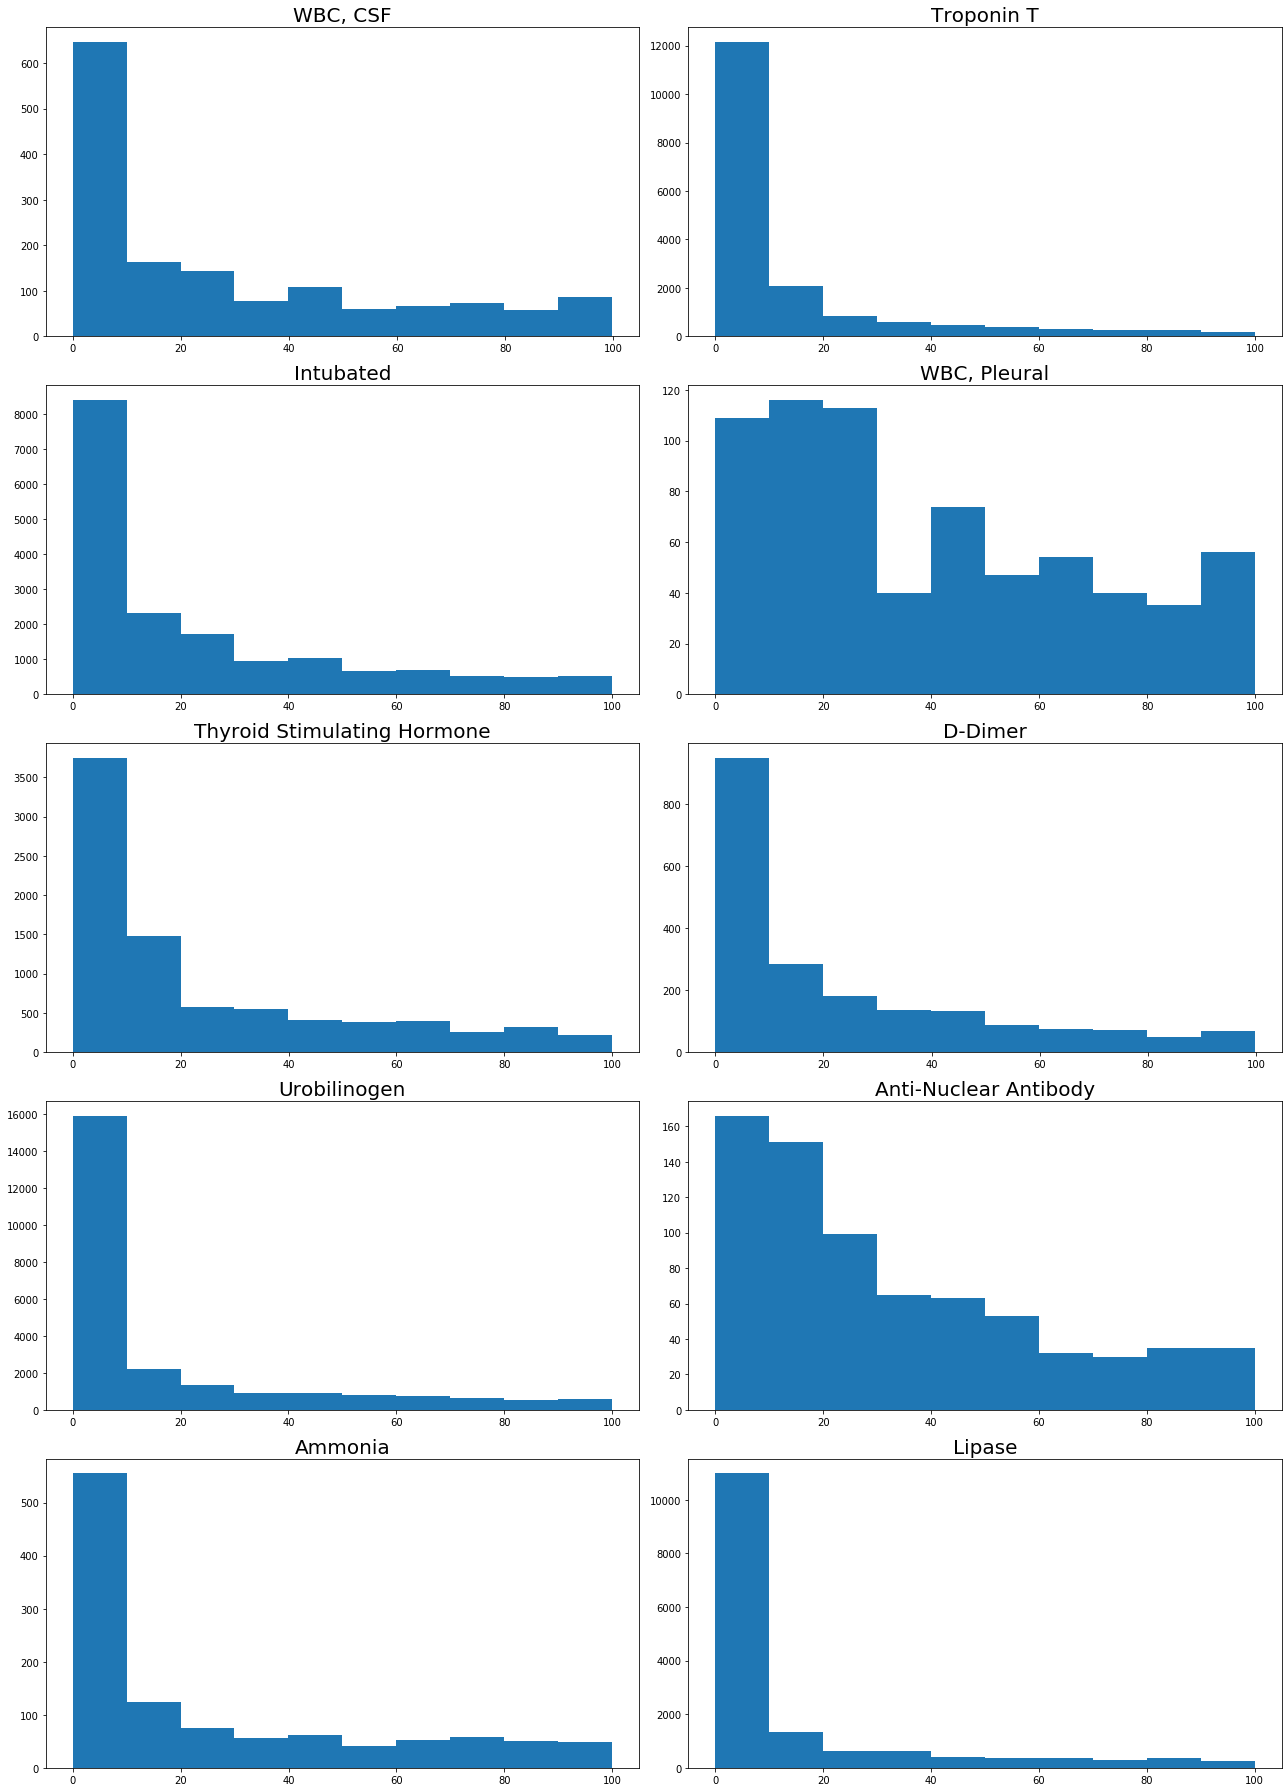

In [80]:
event_times = []

fig, ax = plt.subplots(5, 2, figsize=(18, 25))

for i, lbl in enumerate(lab_event_labels):
    
    event_i_times = np.array([get_event_time(hadm_id, i) for hadm_id in event_dict.keys()])
    event_times.append(event_i_times)
    ax[i // 2, i % 2].hist(event_i_times[event_i_times<100])
    ax[i // 2, i % 2].set_title(lbl, fontsize=20)
    
plt.tight_layout()
plt.show()